# Lab 2: Multimodal Argument Retrieval using FAISS and Graph Neural Networks

## Objectives
This lab is designed to give you hands-on experience in retrieving arguments and discussions from online forums (e.g., Reddit) using a combination of graph-based reasoning and dense text embeddings. The lab is split into two parts:

**Part 1: Building and Analyzing Multimodal Embeddings**

- Extract structured discussion data from Pushshift (a Reddit archive).
- Construct text embeddings using Sentence Transformers.
- Build graph embeddings for discussions using a Graph Neural Network (GNN).
- Visualize embeddings to explore topic clustering and network structures.

**Part 2: Argument Retrieval using FAISS and LangChain**

- Store dense embeddings in FAISS (a scalable vector database).
- Use LangChain to perform Retrieval-Augmented Generation (RAG).
- Perform semantic search on arguments to retrieve contextually relevant discussions.
- Integrate graph-based similarity for better retrieval.


## Data
* Use data from: https://www.reddit.com/r/pushshift/comments/1itme1k/separate_dump_files_for_the_top_40k_subreddits/
* Use torrent to download one or more subreddits of your choosing
* You can use this script to conver the files to csv https://github.com/Watchful1/PushshiftDumps/blob/master/scripts/to_csv.py


**NOTE:** Remember to run using the GPU

In [ ]:
!pip install torch_geometric faiss-cpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 68.5 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
input_file = '/content/drive/My Drive/teaching/AdvML/Labs/Lab2/data/filtered_data.csv'


Mounted at /content/drive


# Part 1: Embedding generation

In [ ]:
import pandas as pd
import json
import zstandard as zstd
import networkx as nx
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sentence_transformers import SentenceTransformer
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import subprocess
import faiss
import pickle


df = pd.read_csv(input_file)
df = df.dropna()
df = df.reset_index()


# Compute Similarity Edges
print("computing embeddings")
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(df['body'], convert_to_tensor=True)


# Convert embeddings to numpy (FAISS requires float32)
print("converting to numpy")
embeddings_np = embeddings.cpu().numpy().astype('float32')
np.save("/content/drive/My Drive/teaching/AdvML/Labs/Lab2/data/embeddings.npy", embeddings_np)

# Create FAISS index for similarity search
print("creating index")
index = faiss.IndexFlatIP(embeddings_np.shape[1])  # Inner product (cosine similarity)
index.add(embeddings_np)

# Save the FAISS index to a file
faiss.write_index(index, "/content/drive/My Drive/teaching/AdvML/Labs/Lab2/data/faiss.index")
print("FAISS index saved successfully.")

# Perform a search for the top 10 most similar posts for each post
k = 10  # Number of nearest neighbors to retrieve
D, I = index.search(embeddings_np, k)

# Store results in a DataFrame and build the graph
print("computing similarity")
similarity_results = []
G = nx.Graph()
for i in range(len(df)):
    post_id = df.iloc[i]['index']
    G.add_node(post_id, text=df.iloc[i]['body'])
    similar_posts = []
    for j in range(1, k):  # Exclude self-match
        similar_post_id = df.iloc[I[i, j]]['index']
        similarity_score = D[i, j]
        similar_posts.append((similar_post_id, similarity_score))
        G.add_edge(post_id, similar_post_id, weight=similarity_score)
    similarity_results.append({"post_id": post_id, "similar_posts": similar_posts})

# save the graph
pickle.dump(G, open('/content/drive/My Drive/teaching/AdvML/Labs/Lab2/data/graph.pickle', 'wb'))
similarity_df = pd.DataFrame(similarity_results)

# Save this in case that you need to do recomputation
similarity_df.to_json("/content/drive/My Drive/teaching/AdvML/Labs/Lab2/data/faiss_similar_posts.json", orient="records", lines=True)
print("saved similarity results")

# Visualize Graph Structure
plt.figure(figsize=(10, 6))
nx.draw(G, with_labels=False, node_size=20)
plt.title("Graph Structure of subreddit")
plt.show()

# Perform t-SNE for 2D visualization
emb_2d = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(embeddings)
plt.figure(figsize=(8, 6))
plt.scatter(emb_2d[:, 0], emb_2d[:, 1], alpha=0.7, c='blue')
plt.title("t-SNE Visualization of Text Embeddings")
plt.show()


computing embeddings
converting to numpy
creating index
FAISS index saved successfully.
computing similarity
saved similarity results


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import json
import faiss
import pandas as pd
from sentence_transformers import SentenceTransformer
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import subprocess
import pickle

G = pickle.load(open('/content/drive/My Drive/teaching/AdvML/Labs/Lab2/data/graph.pickle', 'rb'))
embeddings_np = np.load("/content/drive/My Drive/teaching/AdvML/Labs/Lab2/data/embeddings.npy")

Node feature matrix shape: torch.Size([896903, 384])
Epoch 1, Loss: 0.0039
Epoch 2, Loss: 0.0070
Epoch 3, Loss: 0.0021
Epoch 4, Loss: 0.0021
Epoch 5, Loss: 0.0020
Epoch 6, Loss: 0.0019
Epoch 7, Loss: 0.0018
Epoch 8, Loss: 0.0017
Epoch 9, Loss: 0.0017
Epoch 10, Loss: 0.0017
Epoch 11, Loss: 0.0016
Epoch 12, Loss: 0.0016
Epoch 13, Loss: 0.0016
Epoch 14, Loss: 0.0016
Epoch 15, Loss: 0.0016
Epoch 16, Loss: 0.0016
Epoch 17, Loss: 0.0016
Epoch 18, Loss: 0.0016
Epoch 19, Loss: 0.0016
Epoch 20, Loss: 0.0016
converting to numpy


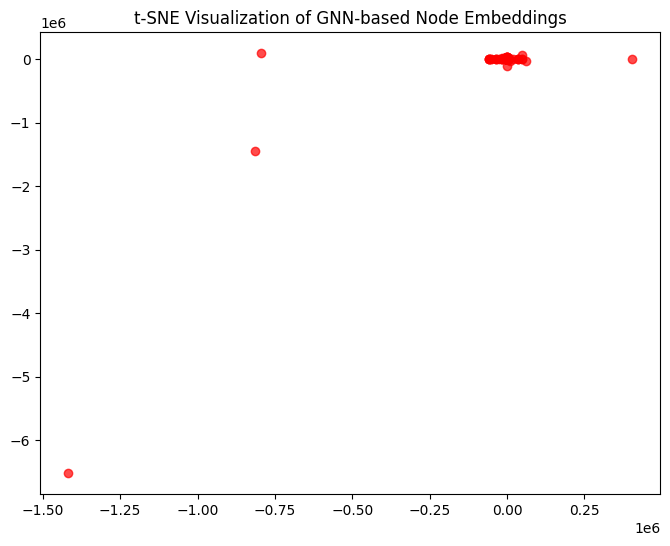

In [ ]:


# Define GNN Model for Node Embeddings

class GNN(nn.Module):
    def __init__(self, input_dim=384, hidden_dim=128, output_dim=384):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x

def train(model, data, epochs=20):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = criterion(out, data.x)  # Unsupervised training
        loss.backward()
        optimizer.step()
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")
    return out


# Convert Graph to PyTorch Geometric Data Format
node_mapping = {node: i for i, node in enumerate(G.nodes())}
edges = np.array([(node_mapping[u], node_mapping[v]) for u, v in G.edges()])
x = torch.tensor(embeddings_np, dtype=torch.float)
edge_index = torch.tensor(edges.T, dtype=torch.long)
data = Data(x=x, edge_index=edge_index)


# Train GNN Model
model = GNN(input_dim=384, hidden_dim=128, output_dim=384)
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()


print("Node feature matrix shape:", data.x.shape)  # Should be (num_nodes, feature_dim)

# Train and obtain new node embeddings
node_embeddings = train(model, data)
torch.save(model.state_dict(), "/content/drive/My Drive/teaching/AdvML/Labs/Lab2/data/gnn_embeddings.pt")

# Convert embeddings to numpy (FAISS requires float32)
print("converting to numpy")
node_embeddings_np = node_embeddings.cpu().detach().numpy().astype('float32')
np.save("/content/drive/My Drive/teaching/AdvML/Labs/Lab2/data/node_embeddings.npy", node_embeddings_np)


# Visualize Node Embeddings using t-SNE
node_emb_2d = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(node_embeddings.detach().numpy())
plt.figure(figsize=(8, 6))
plt.scatter(node_emb_2d[:, 0], node_emb_2d[:, 1], alpha=0.7, c='red')
plt.title("t-SNE Visualization of GNN-based Node Embeddings")
plt.show()




# Part 2: Retrieval Augmented Generation

In [ ]:
!pip install -U langchain-community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 89.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 61.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 415.4/415.4 kB 36.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 5.1 MB/s eta 0:00:00
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.40
    Uninstalling langchain-core-0.3.40:
      Successfully uninstalled langchain-core-0.3.40
  Attempting uninstall: langchain
    Found existing installation: langchain 0.3.19
    Uninstalling langchain-0.3.19:
      Successfully uninstalled langchain-0.3.19


In [ ]:

from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain.chains import RetrievalQA
from langchain.chat_models import ChatOpenAI
from langchain.schema import Document

# Load FAISS index and data
faiss_index_file = "/content/drive/My Drive/teaching/AdvML/Labs/Lab2/data/faiss.index"
similarity_data_file = "/content/drive/My Drive/teaching/AdvML/Labs/Lab2/data/faiss_similar_posts.json"
embeddings_np = np.load("/content/drive/My Drive/teaching/AdvML/Labs/Lab2/data/embeddings.npy")


# Load original posts
df = pd.read_csv(input_file)
df = df.dropna()
df = df.reset_index()

# Load FAISS index
index = faiss.read_index(faiss_index_file)
embedding_dim = index.d # get the embedding dimension from faiss
assert embeddings_np.shape[1] == embedding_dim, "Embedding dimension mismatch"
#index.add(embeddings_np)


# Create FAISS-based retriever
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
vectorstore = FAISS(embeddings, index, {})
retriever = vectorstore.as_retriever()

# Set up LLM-based QA system
llm = ChatOpenAI(model_name="gpt-4")
qa_chain = RetrievalQA.from_chain_type(llm, retriever=retriever)

# Example query
query = "What are the key arguments in favor and against tariffs?"
response = qa_chain.run(query)
print("Response:", response)


# Lab Steps

From the following 4 points, chose at least 2 of them and implement the suggested improvements. Note that you can also select and implement your own improvements to the lab. The goal is for you to gain some practical experience dealing with multimodal embeddings and/or RAG


## **1. Improve Graph Embeddings with Random Walks (Node2Vec)**
Instead of relying solely on a GCN-based approach, implement **Node2Vec**, a random walk-based technique for generating graph embeddings. This approach captures **structural properties** of the graph.

### **Steps to use Node2Vec to generate graph gmbeddings:**
   - Install `torch_geometric` extensions:  
     ```bash
     pip install torch-geometric torch-sparse torch-scatter
     ```
   - Modify the code to use **Node2Vec**:
     ```python

     # Define Node2Vec model - example
     node2vec = Node2Vec(edge_index, embedding_dim=128, walk_length=10, context_size=5, walks_per_node=10, num_negative_samples=1, sparse=True)
    ```
   - Train the model
    
   - Produce node embeddings

   - Visualize embeddings and compare visualizations

---

## **2. Combine Graph and Text Embeddings into a Multimodal Representation**
Instead of treating text and graph separately, merge them into a **joint embedding space**.

### **Methods to Combine Graph and Text Embeddings**
#### **A. Concatenation**
Combine graph embeddings (`node2vec`) with sentence embeddings (`SentenceTransformer`):
```python
combined_embeddings = torch.cat((text_embeddings, node_embeddings), dim=1)
```

#### **B. Attention-Based Fusion**
Use a **Transformer-based attention mechanism** to weigh the importance of text vs. graph (example):
```python
import torch.nn.functional as F
from torch_geometric.nn import GATConv

class GNNWithAttention(nn.Module):
    def __init__(self, text_dim, graph_dim, hidden_dim):
        super(GNNWithAttention, self).__init__()
        self.text_fc = nn.Linear(text_dim, hidden_dim)
        self.graph_fc = nn.Linear(graph_dim, hidden_dim)
        self.gat = GATConv(hidden_dim, hidden_dim, heads=4)

    def forward(self, text_emb, graph_emb, edge_index):
        text_hidden = F.relu(self.text_fc(text_emb))
        graph_hidden = F.relu(self.graph_fc(graph_emb))
        combined = text_hidden + graph_hidden  # Attention could be applied here
        out = self.gat(combined, edge_index)
        return out
```

---

## **3. Improve Text Processing with Context-Aware Models**
Instead of using `all-MiniLM-L6-v2`, experiment with:
- **Long-form debate models**: `mistral-7b-instruct`  
- **Graph-aware NLP models**: `GraphFormers`

---

## **4. Experiment with Different RAG Retrieval Strategies**
Once embeddings are improved, test different retrieval techniques:
- **Graph-based retrieval**: Use **random walk proximity** to rank arguments.
- **Hybrid search**: Combine **FAISS (vector search)** with **Graph Traversal**.
- **Context re-ranking**: Use **Cross-Encoder BERT** models to improve final ranking.

---

### **Deliverables**

* Notebook with code and explanations.
* Report summarizing findings and insights, include visualizations comparing model predictions.
